In [1]:
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import vq
import matplotlib.pyplot as plt

# Load the dataset directory path
# data_dir = "M:/Datasets/aloi_ill/png"  # Update this to your dataset path
data_dir = r"C:\Users\Administrator\Desktop\EfficientNet\Augmented_Data copy"  # Update this to your dataset path

image_paths = []
labels = []

# Load images and assign labels based on folder names
for label in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, label)
    if os.path.isdir(class_dir):
        for file in os.listdir(class_dir):
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, file))
                labels.append(int(label))  # Convert folder name to integer label

# Step 1: Compute SIFT descriptors for each image
sift = cv2.SIFT_create()
descriptors_list = []
valid_image_paths = []
valid_labels = []

for image_path, label in zip(image_paths, labels):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load image {image_path}. Skipping.")
        continue  # Skip images that can't be loaded

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None and len(descriptors) > 0:
        descriptors_list.append(descriptors)
        valid_labels.append(label)  # Only add the label if descriptors are found
        valid_image_paths.append(image_path)
    else:
        print(f"Warning: No descriptors found for image {image_path}. Skipping.")

if len(descriptors_list) == 0:
    raise ValueError("No valid SIFT descriptors found in the dataset. Ensure images have enough texture.")

# Step 2: Flatten all descriptors for clustering
all_descriptors = np.vstack(descriptors_list)
num_clusters = 50  # Define the number of visual words
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(all_descriptors)
visual_words = kmeans.cluster_centers_

# Compute histogram for each image based on the visual words
def compute_histogram(descriptors, visual_words):
    words, _ = vq(descriptors, visual_words)
    hist, _ = np.histogram(words, bins=np.arange(len(visual_words) + 1))
    return hist

# GLAC feature extraction
def compute_glac_features(image, patch_size=8, bins=8):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    orientation = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 360

    orientation_bin = np.floor(orientation / (360 / bins)).astype(np.int32)
    h, w = image.shape
    glac_features = []

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch_magnitude = magnitude[i:i + patch_size, j:j + patch_size]
            patch_orientation_bin = orientation_bin[i:i + patch_size, j:j + patch_size]
            hist = np.zeros((bins, bins))

            for m in range(patch_magnitude.shape[0]):
                for n in range(patch_magnitude.shape[1]):
                    bin1 = patch_orientation_bin[m, n]
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            x, y = m + dx, n + dy
                            if 0 <= x < patch_magnitude.shape[0] and 0 <= y < patch_magnitude.shape[1]:
                                bin2 = patch_orientation_bin[x, y]
                                hist[bin1, bin2] += patch_magnitude[m, n] * patch_magnitude[x, y]

            glac_features.append(hist.flatten())

    return np.concatenate(glac_features)

# Extract combined features
combined_features = []
for image_path, descriptors in zip(valid_image_paths, descriptors_list):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    glac_features = compute_glac_features(gray)
    sift_histogram = compute_histogram(descriptors, visual_words)

    combined_feature = np.concatenate([sift_histogram, glac_features])
    combined_features.append(combined_feature)

combined_features = np.array(combined_features)
valid_labels = np.array(valid_labels)


In [4]:
print(combined_features.shape)
print(valid_labels.shape)

(9987, 27698)
(9987,)


Accuracy: 92.84%


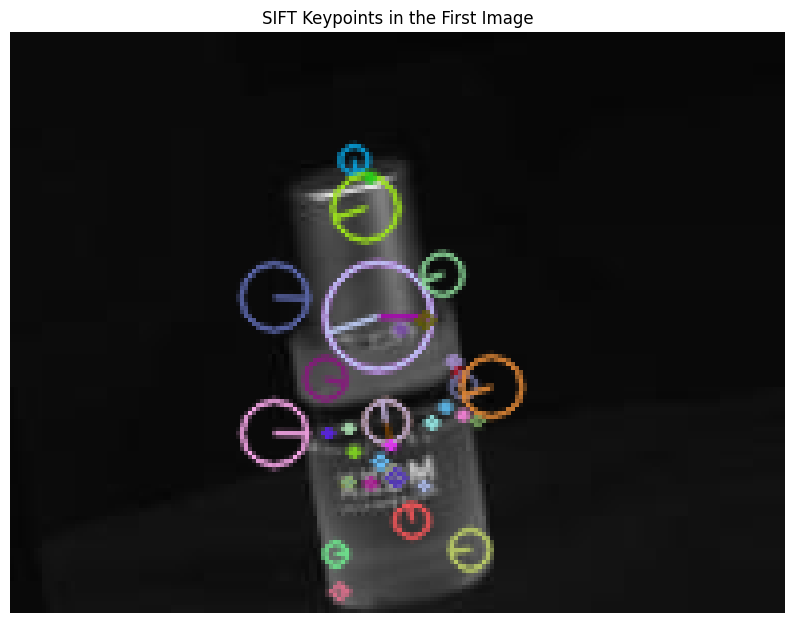

In [5]:

# Step 4: Train and test classifier
X_train, X_test, y_train, y_test = train_test_split(combined_features, valid_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Optional: Visualize SIFT keypoints
first_valid_image_path = valid_image_paths[0]
first_img = cv2.imread(first_valid_image_path)
gray = cv2.cvtColor(first_img, cv2.COLOR_BGR2GRAY)
keypoints, _ = sift.detectAndCompute(gray, None)

img_with_keypoints = cv2.drawKeypoints(
    gray,
    keypoints,
    first_img.copy(),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints in the First Image")
plt.axis("off")
plt.show()
